In [1]:
%load_ext autoreload

In [5]:
from Models.attn import Attention

In [2]:
%autoreload 2
import torch
from utils.metrics import kappa_error,plot_confusion_matrix
import pandas as pd
from training import Network,load_data,prepare_data,evaluate
from Models.Conv_Rnn import convrnn
from Models.DemixingGRU import DemixGRU
from utils.utils import crop
import os
def create_folder(filename):
    if not os.path.exists(filename):
        os.mkdir(filename)

0.5)
  (Linear): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax()
)
Starting Training of model
Epoch10 Avg train Loss: 0.023615026810164048, Avg val Loss: 0.04926263664079749
Epoch20 Avg train Loss: 0.011052954836936421, Avg val Loss: 0.03748725082563317
Epoch 20.......Acc 0.3923611111111111
Epoch30 Avg train Loss: 0.005499267073877463, Avg val Loss: 0.01215645010056703
Epoch40 Avg train Loss: 0.0036637419289272935, Avg val Loss: 0.012035309620525526
Epoch 40.......Acc 0.6458333333333334
Epoch50 Avg train Loss: 0.0022391862197579117, Avg val Loss: 0.009841459082520527
Epoch60 Avg train Loss: 0.0008640957606346255, Avg val Loss: 0.004047178217898245
Epoch 60.......Acc 0.7048611111111112
Epoch70 Avg train Loss: 0.0020297024653590165, Avg val Loss: 0.004946775118941846
Epoch80 Avg train Loss: 0.0013496392374199668, Avg val Loss: 0.013208008719527204
Epoch 80.......Acc 0.6493055555555556
Epoch90 Avg train Loss: 0.0018264954377353645, Avg val Loss: 0.0053939889306607

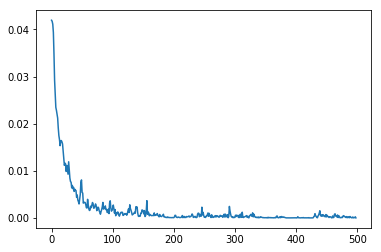

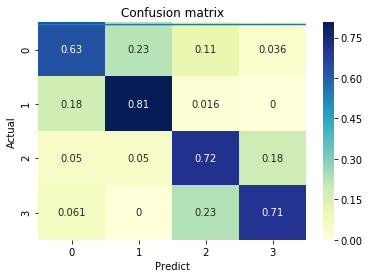

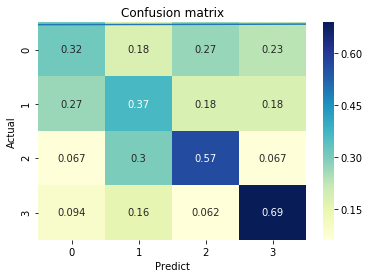

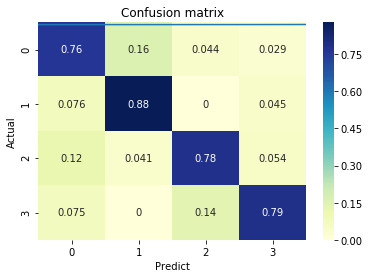

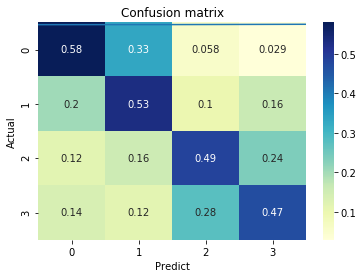

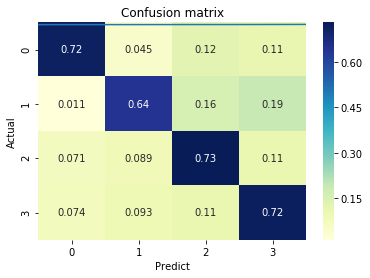

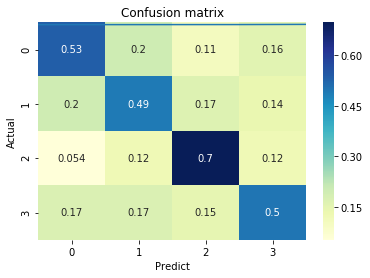

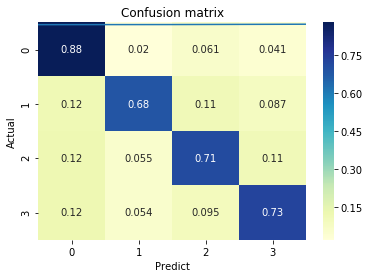

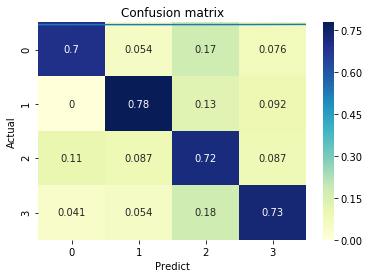

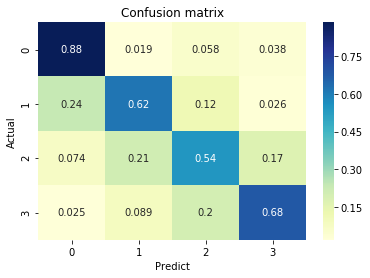

In [11]:
main_dir = '/home/zerowitone/Desktop/Chapter 5/NeuroPrint/Neuro/Datasets'
datasets = ['bci_iv_2b_dataset','bci_iv_2a_dataset','highGamma','bci_iv_2a_raw','bci_iv_2b_dataset_raw','highGamma_raw']

dataset_name = datasets[-3]
dataset = os.path.join(main_dir, dataset_name)
#dataset = 'bciiv2a/non_stand'

#ival = None
ival = [62,562]
acc = list()
PATH = os.path.join(main_dir,'results')


experiments = {}
attentions = {}
experiment_name = os.path.join(PATH,dataset_name +'_no_attn_2s_200_50')

models = os.path.join(experiment_name,'models')
confusionMatrix = os.path.join(experiment_name,'confusionMatrix')
create_folder(experiment_name)
create_folder(models)
create_folder(confusionMatrix)

    
for i in range(1,10,1):
    subject = os.path.join(models,os.path.split(dataset)[1] +'_'+ str(i)+'.pt')

    train_set, test_set = load_data(i, datasetName = os.path.join('../',dataset), ival = ival)
    train_set, test_set = crop(train_set, test_set)
    train_set, valid_set, test_set = prepare_data(train_set, test_set, one_hot= False,val_percentatge= 0.2)
    
    #train_set, valid_set, test_set = format_for_rnn(train_set, valid_set, test_set)
    print(train_set.X.shape)
    #net = DRNN(n_input = input_dim, n_hidden = 10, n_layers= 3, dropout=0, cell_type='GRU', batch_first=True)
    #net = CONVDRNN()
    net= convrnn(classes = 4, inchans = 22)

    #net= convrnn(classes = 2, inchans = 3)
    model = Network(model=net,batch_size=32)
    test_acc,alphas,spat_attn, net  = model.train(train_set, valid_set,test_set,n_epochs = 500)
    attentions[i] = [alphas,spat_attn]
    acc.append(test_acc)
    
    torch.save(model.model.state_dict(), subject)

    _, preds = evaluate(model.model,test_set,model.iterator, pred = True)
    cm , ov_acc = kappa_error(test_set.y.squeeze(),preds)
    fbeta = cm.F_beta(beta=2)
    fbeta = {k:round(v,2) for k,v in fbeta.items()}
    experiments[i] = [test_acc, cm.Kappa, ov_acc] 
    filename = subject.replace(models,confusionMatrix)
    filename = filename.replace('.pt','.png')
    
    ax = plot_confusion_matrix(cm)
    ax.figure.savefig(filename)
    #del model, train_set, test_set,valid_set
re = pd.DataFrame(experiments)
filename = experiment_name + '.csv'
re.to_csv(filename, index= False)

In [12]:
import pandas as pd
import numpy as np
print(np.mean(acc))
print(acc)
print(attentions[1][0].shape)
att_1 = attentions[1][0].cpu().detach().numpy()
df = pd.DataFrame(columns = np.arange(1,23,1))
#print(att_1.shape)
for step in att_1:
    df = df.append(pd.Series(step[0,:,0]),ignore_index=True)
#print(df.describe())
print(len(df.mean()))


0.6435185185185185
[0.7083333333333334, 0.3993055555555556, 0.8020833333333334, 0.5104166666666666, 0.6979166666666666, 0.5451388888888888, 0.7361111111111112, 0.7291666666666666, 0.6631944444444444]
torch.Size([32, 6])


IndexError: too many indices for array

In [19]:
import numpy as np
print(np.mean(acc))
print(acc)
kappas = []
for key, value in experiments.items():
    kappas.append(value[1])
print('Kappas',np.mean(kappas))


0.6693672839506174
[0.7048611111111112, 0.4305555555555556, 0.8159722222222222, 0.5972222222222222, 0.71875, 0.5590277777777778, 0.7118055555555556, 0.7326388888888888, 0.7534722222222222]
Kappas 0.5591563786008229


In [10]:
#%ls
ival = [62,1000]
net= convrnn(classes = 4, inchans = 22)
net.load_state_dict(torch.load('Results/bci_iv_2a_raw_rep_attn_4s_400_50/models/bci_iv_2a_raw_3.pt'))

In [8]:
import torch.nn as nn
modules = []
class x_back(nn.Module):
    def __init__(self):
        super(x_back, self).__init__()
    def forward(self,x):
        return x[0]
mod_1 = x_back()
#print(net)
for i,module in enumerate(net.children()):
    #print(i,module)
    if i == 0:
        modules.append(module)
    """
    if i == 1:
        modules.append(module)
        modules.append(mod_1 )
    
    if i <= 3 and i != 1:
        modules.append(module)
    """
sequential = nn.Sequential(*modules)
print(sequential)

Sequential(
  (0): convLayer(
    (conv): Conv2d(1, 1, kernel_size=(1, 25), stride=(1, 1), padding=(0, 12))
    (bn): BatchNorm2d(1, eps=1e-05, momentum=0.993, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=True)
  )
)


In [11]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
datasets = ['bci_iv_2b_dataset','bci_iv_2a_dataset','highGamma','bci_iv_2a_raw','bci_iv_2b_dataset_raw','highGamma_raw']
ival = [62,1000]
dataset_name = datasets[-3]
dataset = 'Datasets/' + dataset_name
train_set, test_set = load_data(3, datasetName = os.path.join('../',dataset), ival = ival)
train_set, test_set = crop(train_set, test_set)
train_set, valid_set, test_set = prepare_data(train_set, test_set, one_hot= False,val_percentatge= 0.2)

Loaded: ../Datasets/bci_iv_2a_raw/3_set.pkl
Window size: 400, step: 50
train_win_x shape:  (288, 11, 400, 22)
test_win_x shape:  (288, 11, 400, 22)
train_win_x shape:  (288, 11, 22, 400)
test_win_x shape:  (288, 11, 22, 400)
(288, 1)
Train set: 230, Valid set: 58, Test set: 288


In [12]:
x= torch.from_numpy(train_set.X).float().to('cpu')
x = x.permute(0, 1,4, 2, 3)
x = x.reshape(x.size(0)*11,x.size(2),x.size(3),x.size(4))
sequential = sequential.cpu()
outputs = sequential(x)
print(outputs.shape)



torch.Size([2530, 1, 22, 400])


In [14]:
x = outputs.squeeze(1).view(-1,22*400)
x_subset = x.cpu().detach().numpy()
print(x_subset.shape)
RS = 123
test_tsne = TSNE(random_state=RS).fit_transform(x_subset[0:500])

(2530, 8800)


In [73]:
print(test_tsne.shape)
pca_50 = PCA(n_components=2)
pca_result_50 = pca_50.fit_transform(x_subset[0:500])
test_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(pca_result_50)
#fashion_scatter(test_tsne,train_set.y[0:500])

(500, 2)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.971618
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.623459
[t-SNE] KL divergence after 300 iterations: 0.412595


In [74]:
df_subset = pd.DataFrame( {'tsne-2d-one': test_tsne[:,0],'tsne-2d-two': test_tsne[:,1]}   )
#df_subset['tsne-2d-one'] = test_tsne[:,0]
#df_subset['tsne-2d-two'] = test_tsne[:,1]
test_tsne[:,0].shape
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df_subset,
    legend="full",
    alpha=0.3
)

ValueError: Could not interpret input 'y'

<Figure size 1152x720 with 0 Axes>

In [55]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    

    return f, ax, sc, txts

In [ ]:
ok = test_set.X[np.where(test_set.y == 1)
print(ok.shape)
print(test_set.X.shape,classes[1].shape)

In [59]:
np.mean(test_tsne, axis=0)

array([-0.0268688 ,  0.21715415], dtype=float32)

In [31]:

C_sensors = ['FC5', 'FC1', 'FC2', 'FC6', 'C3', 'C4', 'CP5',
                     'CP1', 'CP2', 'CP6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2',
                     'C6',
                     'CP3', 'CPz', 'CP4', 'FFC5h', 'FFC3h', 'FFC4h', 'FFC6h',
                     'FCC5h',
                     'FCC3h', 'FCC4h', 'FCC6h', 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h',
                     'CPP5h',
                     'CPP3h', 'CPP4h', 'CPP6h', 'FFC1h', 'FFC2h', 'FCC1h', 'FCC2h',
                     'CCP1h',
                     'CCP2h', 'CPP1h', 'CPP2h']
channels = {}
for i,channel in enumerate(C_sensors):
    channels[i]= channel
channels[9]

'CP6'

In [ ]:
g = sns.FacetGrid(first_sec)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import normalize
plt.rcParams["figure.figsize"] = 5,5


attn = attentions[0]
time_attn = time_attentions[0]
attn = attn.squeeze(1)
test_spat = attn[10]

test_time = time_attn[10]
print(len(attentions[0]))
#test = torch.transpose(test,1,0)
first_sec = test_batch[10,0,:,:,0]
sec_second = test_batch[10,1,:,:,0]
print(type(test_spat), type(first_sec))
#print(test.shape)
x = torch.mul(test_spat,first_sec)
y = torch.zeros((x.size()))
z = torch.zeros((x.size()))
for i,n in enumerate(x):
    y[i] = n * test_time[0]
    z[i] = n * test_time[1]
print(z == y)
plt.figure()
ch = x
ch = ch.cpu().detach().numpy()
ch = normalize(ch)
ax = sns.heatmap(ch)
ax.set_yticklabels(C_sensors)
ax.plot()



plt.figure()
ch = z 
ch = ch.cpu().detach().numpy()
ch = normalize(ch)
ax2 = sns.heatmap(ch)
ax2.set_yticklabels(C_sensors)
ax2.plot()

In [ ]:
%autoreload 2
from vis import CNNLayerVisualization as cnnvis

from grad_cam import GradCam

model = convrnn(classes = 4, inchans = 44)

model.load_state_dict(torch.load(subject))
model = model.cuda()
#print(model)
#layer_vis = cnnvis(model, 2, 2)
test_batch = torch.from_numpy(test_set.X)
test_batch = test_batch.cuda()
print(test_batch.size())
t = test_set.X
print(t.shape)
#gen = layer_vis.visualise_layer_with_hooks(example = t)
grad_cam = GradCam(model, target_layer=2)
cam, all_left = grad_cam.generate_cam(test_batch, 0)

In [ ]:
model_output = torch.randn((160,4))
one_hot_output = torch.FloatTensor(160, model_output.size()[-1]).zero_()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 44,2

x = ch
y = ch

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

ax.imshow(y[np.newaxis,:], aspect="auto")
ax.set_yticks([])


ax2.plot(x)

plt.tight_layout()
plt.show()

In [ ]:

%autoreload 2
datasets = ['bci_iv_2b_dataset','bci_iv_2a_dataset','highGamma','bci_iv_2a_raw']
dataset = 'Datasets/' + datasets[3]
#dataset = 'bciiv2a/non_stand'

#ival = None
ival = [62,562]
acc = list()

experiments = {}

experiments = {}
all_participants_X = []
all_participants_y = []
for i in range(1,10,1):
    subject = os.path.join(models,os.path.split(dataset)[0] +'_'+ str(i)+'.pt')

    train_set, test_set = load_data(i, datasetName = os.path.join('../',dataset), ival = ival)
    train_set, test_set = crop(train_set, test_set)
    
    all_participants_X.append(train_set.X)
    all_participants_X.append(test_set.X)
    all_participants_y.append(train_set.y)
    all_participants_y.append(test_set.y)

#train_set, valid_set, test_set = prepare_data(train_set, test_set, one_hot= False,val_percentatge= 0.2)


In [ ]:
"""
train_set.X = np.concatenate(all_participants_X)
train_set.y = np.concatenate(all_participants_y)

In [ ]:

"""
print(train_set.X.shape)

net= convrnn(classes = 4, inchans = 22)
#net= convrnn(classes = 2, inchans = 3)
model = Network(model=net,batch_size=32)
test_acc,alphas, net  = model.train(train_set, valid_set,valid_set,n_epochs = 400)
torch.save(net.state_dict(), subject)

_, preds = evaluate(net,test_set,model.iterator, pred = True)
cm , ov_acc = kappa_error(test_set.y.squeeze(),preds)
fbeta = cm.F_beta(beta=2)
fbeta = {k:round(v,2) for k,v in fbeta.items()}
experiments[i] = [test_acc, cm.Kappa, ov_acc] 
filename = subject.replace(models,confusionMatrix)
filename = filename.replace('.pt','.png')
ax = plot_confusion_matrix(cm)
ax.figure.savefig(filename)
del model, train_set, test_set,valid_set
re = pd.DataFrame(experiments)
filename = os.path.join(PATH,'all_pool')
re.to_csv(filename, index= False)


Loaded: ../Datasets/bci_iv_2a_raw/1_set.pkl
Window size: 400, step: 50
train_win_x shape:  (288, 11, 400, 22)
test_win_x shape:  (288, 11, 400, 22)
train_win_x shape:  (288, 11, 22, 400)
test_win_x shape:  (288, 11, 22, 400)
Loaded: ../Datasets/bci_iv_2a_raw/2_set.pkl
Window size: 400, step: 50
train_win_x shape:  (288, 11, 400, 22)
test_win_x shape:  (288, 11, 400, 22)
train_win_x shape:  (288, 11, 22, 400)
test_win_x shape:  (288, 11, 22, 400)
Loaded: ../Datasets/bci_iv_2a_raw/3_set.pkl
Window size: 400, step: 50
train_win_x shape:  (288, 11, 400, 22)
test_win_x shape:  (288, 11, 400, 22)
train_win_x shape:  (288, 11, 22, 400)
test_win_x shape:  (288, 11, 22, 400)
Loaded: ../Datasets/bci_iv_2a_raw/4_set.pkl
Window size: 400, step: 50
train_win_x shape:  (288, 11, 400, 22)
test_win_x shape:  (288, 11, 400, 22)
train_win_x shape:  (288, 11, 22, 400)
test_win_x shape:  (288, 11, 22, 400)
Loaded: ../Datasets/bci_iv_2a_raw/5_set.pkl
Window size: 400, step: 50
train_win_x shape:  (288, 11,

NameError: name 'evaluate_local' is not defined

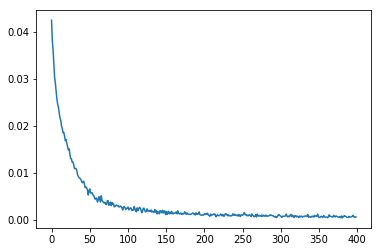

In [3]:
import numpy as np
datasets = ['bci_iv_2b_dataset','bci_iv_2a_dataset','highGamma','bci_iv_2a_raw','bci_iv_2b_dataset_raw','highGamma_raw']

dataset_name = datasets[-3]
dataset = 'Datasets/' + dataset_name
#dataset = 'bciiv2a/non_stand'

#ival = None
ival = [62,1000]
acc = list()
PATH = 'Results'

experiments = {}

experiment_name = os.path.join(PATH,dataset_name +'_across_test_1')

models = os.path.join(experiment_name,'models')
confusionMatrix = os.path.join(experiment_name,'confusionMatrix')
create_folder(experiment_name)
create_folder(models)
create_folder(confusionMatrix)
all_participants_X = []
all_participants_y = []
for i in range(1,10,1):
    subject = os.path.join(models,os.path.split(dataset)[0] +'_'+ str(i)+'.pt')

    train_set, test_set = load_data(i, datasetName = os.path.join('../',dataset), ival = ival)
    train_set, test_set = crop(train_set, test_set)
    
    all_participants_X.append(train_set.X)
    all_participants_X.append(test_set.X)
    all_participants_y.append(train_set.y)
    all_participants_y.append(test_set.y)


for i in range(1,3,1):
    train_X = all_participants_X
    train_y = all_participants_y
    p_index = i-1
    print('Subject for testing: ',p_index, i)
    test_p = train_X.pop(p_index)
    test_p = np.concatenate((test_p,all_participants_X.pop(p_index+9)))
    test_p_y = train_y.pop(p_index)
    test_p_y = np.concatenate((test_p_y ,all_participants_y.pop(p_index+9)))
    
    test_set.X = test_p
    test_set.y = test_p_y
    train_set.X = np.concatenate(all_participants_X)
    train_set.y = np.concatenate(all_participants_y)
    
    train_set, valid_set, test_set = prepare_data(train_set, test_set, one_hot= False,val_percentatge= 0.01)
  
    net= convrnn(classes = 4, inchans = 22)
        #net= convrnn(classes = 2, inchans = 3)
    model = Network(model=net,batch_size=32)
    test_acc,alphas,spat_attn, net  = model.train(train_set, valid_set,test_set,n_epochs = 200)
   
    acc.append(test_acc)

    torch.save(model.model.state_dict(), subject)

    _, preds =  evaluate_local(net,test_set,model.iterator, pred = False)
    cm , ov_acc = kappa_error(test_set.y.squeeze(),preds)
    fbeta = cm.F_beta(beta=2)
    fbeta = {k:round(v,2) for k,v in fbeta.items()}
    experiments[i] = [test_acc, cm.Kappa, ov_acc] 
    filename = subject.replace(models,confusionMatrix)
    filename = filename.replace('.pt','.png')
    plt.figure()
    ax = plot_confusion_matrix(cm)
    ax.figure.savefig(filename)

re = pd.DataFrame(experiments)
print(re)
filename = experiment_name + '.csv'
re.to_csv(filename, index= False)
    #del model, train_set, test_set,valid_set

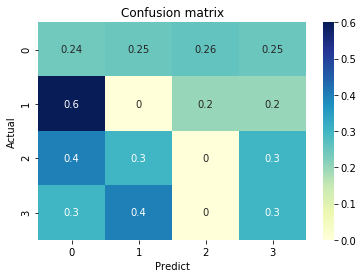

In [6]:
from torch.autograd import Variable
model= convrnn(classes = 4, inchans = 22)
model.load_state_dict(torch.load(subject))
model = model.cuda()
model = Network(model=model,batch_size=32)

_,preds = evaluate_local(model.model,test_set, train_iterator = model.iterator)
test_acc  = evaluate(model.model,test_set,model.iterator)
cm , ov_acc= kappa_error(test_set.y.squeeze(), preds.astype(int))
fbeta = cm.F_beta(beta=2)
fbeta = {k:round(v,2) for k,v in fbeta.items()}
experiments[i] = [test_acc, cm.Kappa, ov_acc] 
filename = subject.replace(models,confusionMatrix)
filename = filename.replace('.pt','.png')
ax = plot_confusion_matrix(cm)
ax.figure.savefig(filename)

re = pd.DataFrame(experiments)
filename = experiment_name + '.csv'
re.to_csv(filename, index= False)



In [7]:
print(_, test_acc, ov_acc, cm.Kappa)

0.6649305555555556 0.6649305555555556 0.2378472222222222 -0.01620370370370372


In [ ]:
names = {}
label = 0
label_mid = int(3500/2) # change this to the end of the first class
for i in range(3501):
    if i == label_mid:
        label = 1
    names[i] = [str(i),label]
df = pd.DataFrame(names)
filename = 'manifold.csv'
df.to_csv(filename, index= false)

In [5]:
def evaluate_local(model, test_set, train_iterator, pred = False):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    outputs = []
    targets = []
    total = 0
    correct = 0
    predictions = np.zeros((len(test_set.X)))
    batch_number = 0
    print(train_iterator)
    for inputs,targets in train_iterator.get_batches(test_set, shuffle= True):
        input_vars = torch.from_numpy(inputs).float().to(device)
        target_vars = torch.from_numpy(targets).long().to(device)
        target_vars = Variable(target_vars.view(-1))
        #print(input_vars.size())
       
        out, alphas, spat_attn = model(input_vars.to(device).float())
        _,predicted = torch.max(out.data,1)  
        correct_pred = torch.eq(target_vars, predicted)
        correct += torch.sum(correct_pred).item()
        total += len(target_vars)
        
        predicted = predicted.detach().cpu().numpy()
        predictions[batch_number: batch_number+len(targets)] = predicted

    
    return correct/total, predictions

In [ ]:
def sequence_generator(X_set, y_set):
    for X, y in zip(X_set, y_set):
        yield X,y

In [ ]:
gen =  sequence_generator(test_set.X, test_set.y)

In [ ]:
x, y = next(gen)

In [ ]:
x.shape

In [ ]:
def evaluate(model, test_set, train_iterator, pred = False):
    model.eval()
    outputs = []
    targets = []
    total = 0
    correct = 0
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for inputs,targets in train_iterator.get_batches(test_set, shuffle= True):
        input_vars = torch.from_numpy(inputs).float().to(device)
        target_vars = torch.from_numpy(targets).long().to(device)
        target_vars = Variable(target_vars.view(-1))
        #print(input_vars.size())
       
        out, alphas, spat_attn = model(input_vars.to(device).float())
        _,predicted = torch.max(out.data,1)
        outputs.append(predicted.detach().cpu().numpy().flatten())
        correct_pred = torch.eq(target_vars, predicted)
        #print(predicted[0],target_vars[0])
        #print(torch.sum(correct_pred))
        correct += torch.sum(correct_pred).item()
        total += len(target_vars)
        #print(correct)
        
    #print(correct/total)
    if pred:
        input_vars = torch.from_numpy(test_set.X).float().to(device)
        target_vars = torch.from_numpy(test_set.y).long().to(device)
        out, alphas,spat_attn = model(input_vars.to(device).float())
        _,predicted = torch.max(out.data,1)
        predicted = predicted.detach().cpu().numpy()
        return correct/total, predicted
    else:
        return correct/total

In [ ]:
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
def evaluate_AUC(model, test_set, train_iterator, pred = False):
    model.eval()
    outputs = []
    targets = []
    total = 0
    correct = 0
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for inputs,targets in train_iterator.get_batches(test_set, shuffle= True):
        input_vars = torch.from_numpy(inputs).float().to(device)
        target_vars = torch.from_numpy(targets).long().to(device)
        target_vars = Variable(target_vars.view(-1))
        #print(input_vars.size())
       
        out, alphas, spat_attn = model(input_vars.to(device).float())
        _,predicted = torch.max(out.data,1)
        outputs.append(predicted.detach().cpu().numpy().flatten())
        correct_pred = torch.eq(target_vars, predicted)
        #print(predicted[0],target_vars[0])
        #print(torch.sum(correct_pred))
        correct += torch.sum(correct_pred).item()
        total += len(target_vars)
        out = torch.sigmoid(out.data)
        
        target_vars = target_vars.cpu().detach().numpy()
        out = out.cpu().detach().numpy()
        print(target_vars.shape, out.shape)
        auc_roc_test = multiclass_roc_auc_score(y_true=target_vars, y_score=out)
     
        print(auc_roc_test)
        
    #print(correct/total)
    if pred:
        input_vars = torch.from_numpy(test_set.X).float().to(device)
        target_vars = torch.from_numpy(test_set.y).long().to(device)
        out, alphas,spat_attn = model(input_vars.to(device).float())
        _,predicted = torch.max(out.data,1)
        predicted = predicted.detach().cpu().numpy()
        return correct/total, predicted
    else:
        return correct/total


In [ ]:
evaluate_AUC(model.model,test_set,model.iterator)

In [ ]:
def multiclass_roc_auc_score(y_true, y_score):
    assert y_true.shape == y_score.shape
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_true.shape[1]
    # compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # compute macro-average ROC curve and ROC area
    # First aggregate all false probtive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc
